In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import IPython
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from torchvision import transforms,datasets,models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Current device: {device}")
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST('data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data', train=False, download=True, transform=transform)

training_loader = DataLoader(train_set,batch_size=64, shuffle=True,pin_memory=True)
validation_loader = DataLoader(test_set,batch_size=16,shuffle=True,pin_memory=True)

Current device: cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 114462691.84it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31435012.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3476373.86it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Define the Residual block and ResidualBlocks class
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.block(x) + x
        return self.block(x) + x

class ResidualBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, residual_layers, hidden_channels):
        super(ResidualBlocks, self).__init__()
        self.residual_layers = residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, out_channels, hidden_channels)
                for _ in range(self.residual_layers)
            ]
        )

    def forward(self, x):
        for i in range(self.residual_layers):
            x = F.relu(x + self.layers[i](x))
        return x

In [4]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels=128, hidden_layers=32, residual_layers=2):
        super(Encoder, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU()
        )
        self.residual_block = ResidualBlocks(out_channels, out_channels, residual_layers, hidden_layers)

    def forward(self, x):
        x = self.residual_block(self.layer_3(self.layer_2(self.layer_1(x))))
        return x

In [5]:
sample_input = torch.randn(1, 3, 64, 64)  # Creating a sample input tensor
encoder = Encoder(in_channels=3)
print(f" Encoder output shape: {encoder(sample_input).shape}")

 Encoder output shape: torch.Size([1, 128, 16, 16])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the VectorQuantization class
class VectorQuantization(nn.Module):
    def __init__(self, number_embeddings, embedding_dimension):
        super(VectorQuantization, self).__init__()
        self.num_embeddings = number_embeddings
        self.embedding_dim = embedding_dimension
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, x):
        # Convert (Batch, channel, Height, Width) to (Batch, Height, Width, Channel) for flattening
        x = x.permute(0, 2, 3, 1)
        # Flatten input
        latent = x.reshape(-1, self.embedding_dim)
        # One Hot Encoding starts from here
        encoded_vector = F.one_hot(torch.argmin((torch.sum(latent**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(latent, self.embedding.weight.t())), dim=1).unsqueeze(1), self.num_embeddings).type(x.dtype)
        # Quantization of the Encodings
        quantized_vector = torch.matmul(encoded_vector.view(encoded_vector.shape[0], encoded_vector.shape[2]), self.embedding.weight).view(x.shape)
        # Loss calculation
        vq_loss = F.mse_loss(quantized_vector, x.detach()) + 0.25 * F.mse_loss(quantized_vector.detach(), x)
        # Detach and update quantized vector for backpropagation
        quantized_vector = (x + (quantized_vector - x).detach()).permute(0, 3, 1, 2)
        return quantized_vector, vq_loss

Quantized output shape: torch.Size([1, 3, 64, 64])
VQ Loss: 1.0684595108032227
3


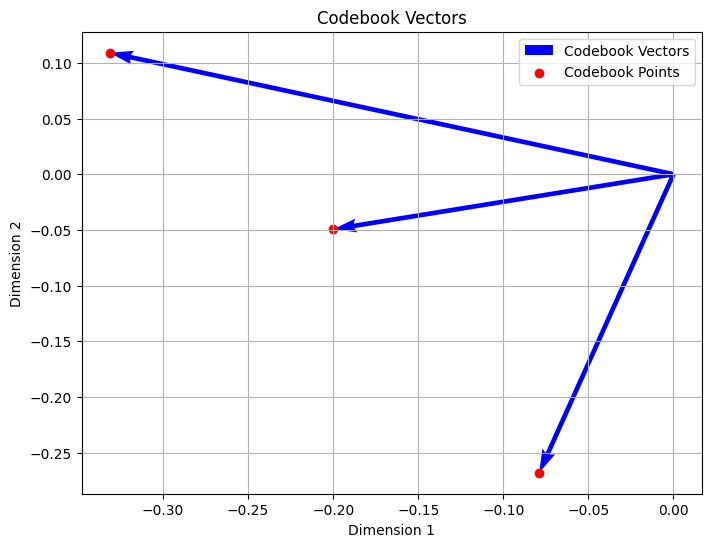

In [7]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Function to plot 2D vectors from the codebook
def plot_codebook_vectors(vq_module):
    # Get the codebook vectors
    codebook = vq_module.embedding.weight.data.cpu().numpy()
    print(len(codebook))
    # Create origin array
    origin = np.zeros((len(codebook), 2))

    # Plot each 2D vector from the codebook
    plt.figure(figsize=(8, 6))
    plt.quiver(*origin.T, codebook[:, 0], codebook[:, 1], angles='xy', scale_units='xy', scale=1, color='b', label='Codebook Vectors')
    plt.scatter(codebook[:, 0], codebook[:, 1], color='r', label='Codebook Points')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Codebook Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot codebook vectors after checking VectorQuantization output
def check_and_plot_codebook():
    # Assuming 3 channels for the input tensor (modify as needed)
    in_channels = 3
    sample_input = torch.randn(1, in_channels, 64, 64)  # Creating a sample input tensor

    # Initialize the VectorQuantization module
    vq = VectorQuantization(number_embeddings=3, embedding_dimension=2)

    # Pass the sample input through the VectorQuantization module
    quantized_output, vq_loss = vq(sample_input)

    # Print the output shape and loss
    print(f"Quantized output shape: {quantized_output.shape}")
    print(f"VQ Loss: {vq_loss}")

    # Plot codebook vectors
    plot_codebook_vectors(vq)

# Call the function to check the output and plot codebook vectors
check_and_plot_codebook()

In [8]:
class Decoder(nn.Module):
    def __init__(self, out_channels=128, residual_layers=2, hidden_layers=32):
        super(Decoder, self).__init__()

        self.inverse_residual_block = ResidualBlocks(out_channels,out_channels,residual_layers,hidden_layers)

        self.trans_layer1 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels,out_channels//2,4,2,1),
                                    nn.ReLU()
        )
        self.trans_layer2 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels//2,3,4,2,1),
        )

    def forward(self, x):
        x = self.trans_layer2(self.trans_layer1(self.inverse_residual_block(x)))
        return x

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

sample_input = torch.randn(1, 128, 32, 32)
decoder = Decoder(out_channels=128, residual_layers=2, hidden_layers=32)
output = decoder(sample_input)
print(f"Decoder Output Shape: {output.shape}")

Decoder Output Shape: torch.Size([1, 3, 128, 128])


Training:   0%|          | 0/938 [00:00<?, ?batch/s]

<ipython-input-10-0ad5a444cf2f>:26: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)
<ipython-input-10-0ad5a444cf2f>:26: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)


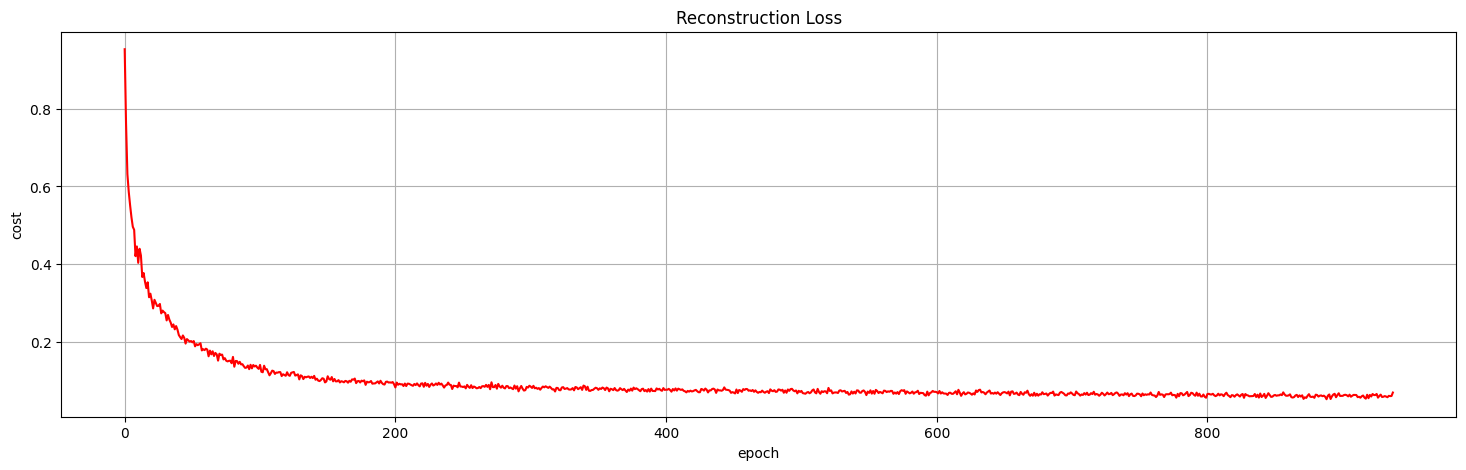

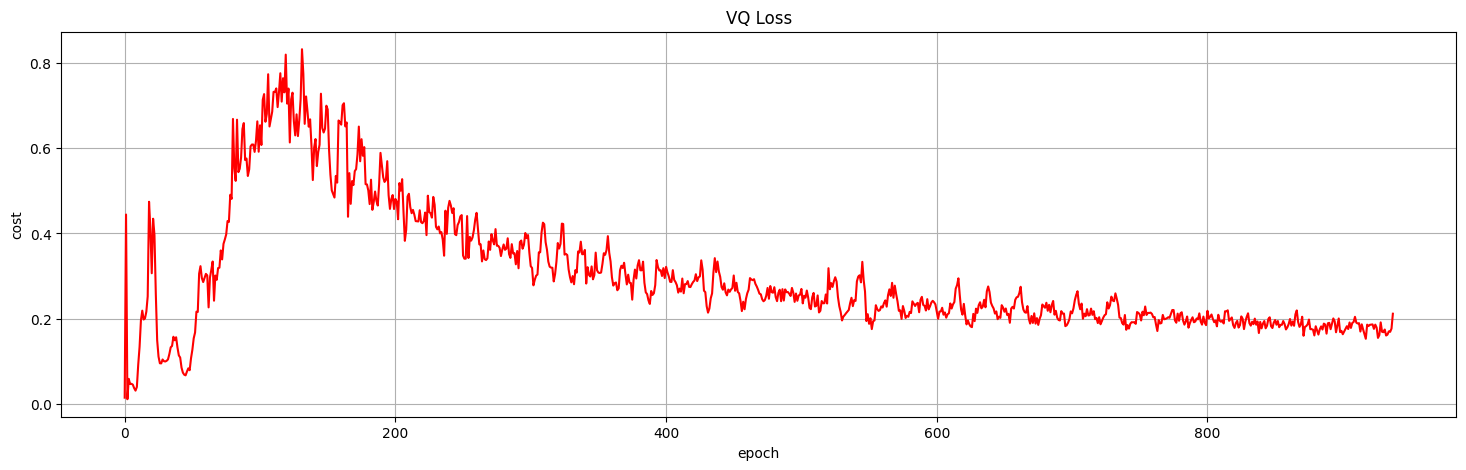

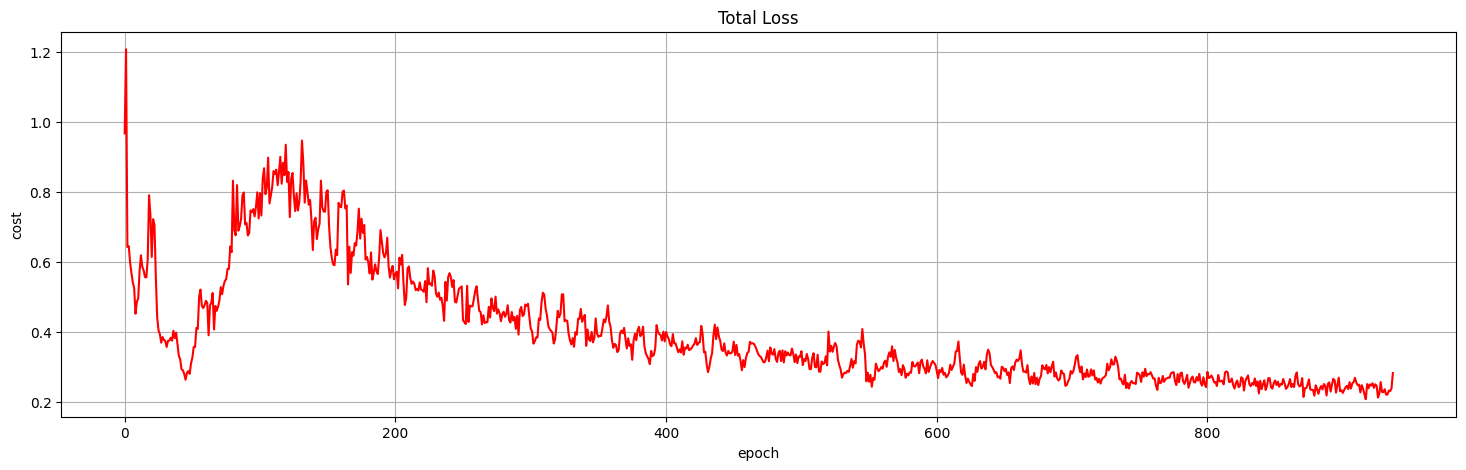

In [10]:
class VQVAENet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, in_channels=1):
        super(VQVAENet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.hidden1 = nn.Conv2d(128, embedding_dim, 1, 1)
        self.vq = VectorQuantization(num_embeddings, embedding_dim)
        self.hidden2 = nn.Conv2d(embedding_dim, 128, 3, 1, 1)
        self.decoder = Decoder()

    def forward(self, x):
        quantized_vector,vq_loss= self.vq(self.hidden1(self.encoder(x)))
        x = self.decoder(self.hidden2(quantized_vector))
        return x,vq_loss
model = VQVAENet(3,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
from tqdm.notebook import tqdm
Recon_loss = []
VQ_loss = []
Total_loss = []
Codebook_vectors = []
model.train()
for data, _ in tqdm(training_loader, desc="Training", unit="batch"):
    data = data.to(device)
    optimizer.zero_grad()
    output, vq_loss = model(data)
    recon_loss = F.mse_loss(output, data)
    loss = recon_loss + vq_loss
    loss.backward()
    optimizer.step()
    Recon_loss.append(recon_loss.item())
    VQ_loss.append(vq_loss.item())
    Total_loss.append(loss.item())
    Codebook_vectors.append(model.vq.embedding.weight.clone().detach().cpu().numpy())
import matplotlib.pyplot as plt

losses = [Recon_loss, VQ_loss, Total_loss]
titles = ["Reconstruction Loss", "VQ Loss", "Total Loss"]
colors = ['r', 'r', 'r']  # Use red color for plots


for i in range(len(losses)):
    plt.figure(figsize=(18, 5))  # Set figure size
    plt.plot(losses[i], color=colors[i])  # Set the color of the plots
    plt.title(titles[i])
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.grid(True)  # Add grid
    plt.show()

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

codebook_1 = np.zeros((len(Codebook_vectors), 2))
codebook_2 = np.zeros((len(Codebook_vectors), 2))
codebook_3 = np.zeros((len(Codebook_vectors), 2))

for i, codebook_vector in enumerate(Codebook_vectors):
    codebook_1[i] = codebook_vector[0,:]
    codebook_2[i] = codebook_vector[1,:]
    codebook_3[i] = codebook_vector[2,:]
codebook_vectors = []
input_images = []
output_images = []

for i, (image, _) in enumerate(tqdm(training_loader, desc="Generating codebook vectors and images", unit="batch")):
    image = image.to(device)
    out_image, vq_loss = model(image)
    codebook_vectors.append(np.column_stack(([codebook_1[i, 0], codebook_2[i, 0], codebook_3[i, 0]], [codebook_1[i, 1], codebook_2[i, 1], codebook_3[i, 1]])))
    input_images.append(image[0].cpu().squeeze().numpy())
    output_images.append(out_image.view(-1, 28, 28).cpu().detach().numpy()[0])

Generating codebook vectors and images: 100%|██████████| 938/938 [00:22<00:00, 42.04batch/s]


<Figure size 1500x500 with 0 Axes>

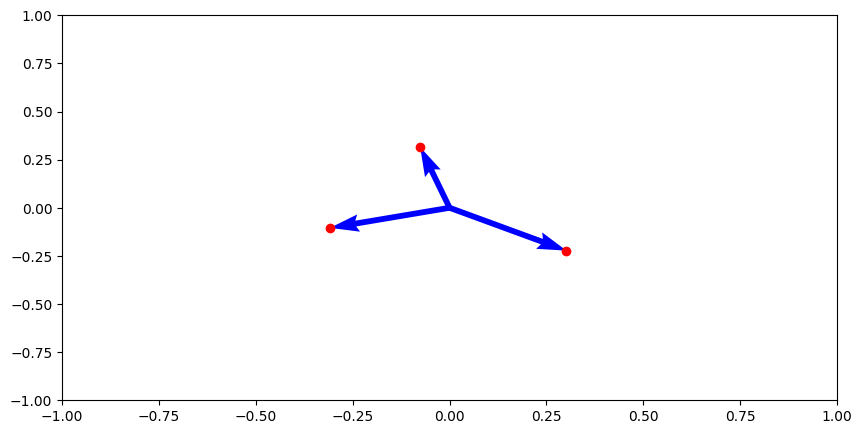

In [12]:
codebook_vectors = codebook_vectors[:500]
input_images = input_images[:500]
output_images = output_images[:500]
def update_plot(i):
    plt.clf()
    origin = np.zeros((3, 2))
    plt.quiver(*origin.T, codebook_vectors[i][:, 0], codebook_vectors[i][:, 1], angles='xy', scale_units='xy', scale=1, color='b', label='Codebook Vectors')
    plt.scatter(codebook_vectors[i][:, 0], codebook_vectors[i][:, 1], color='r', label='Codebook Points')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
fig = plt.figure(figsize=(15, 5))
import matplotlib.animation as animation

# Create the figure and animation
fig = plt.figure(figsize=(10, 5))
ani = animation.FuncAnimation(fig, update_plot, frames=len(codebook_vectors), interval=200)

# Save the animation as a GIF
ani.save('codebook_animation.gif', writer='pillow', fps=20)

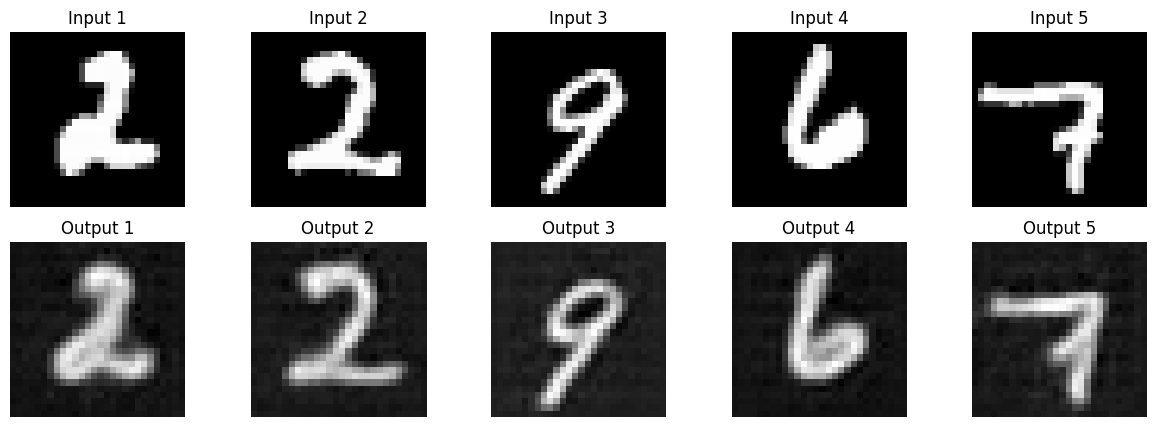

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to update the plot for each frame
def update_plot(i):
    plt.clf()

    # Plot input images
    for j in range(5):
        plt.subplot(2, 5, j + 1)
        plt.imshow(input_images[i * 5 + j], cmap='gray')
        plt.title('Input {}'.format(j + 1))
        plt.axis('off')

    # Plot output images
    for j in range(5):
        plt.subplot(2, 5, j + 6)
        plt.imshow(output_images[i * 5 + j], cmap='gray')
        plt.title('Output {}'.format(j + 1))
        plt.axis('off')

# Create the figure and animation
fig = plt.figure(figsize=(15, 5))
ani = animation.FuncAnimation(fig, update_plot, frames=len(codebook_vectors) // 5, interval=400)

# Save the animation as a GIF
ani.save('output.gif', writer='pillow', fps=20)

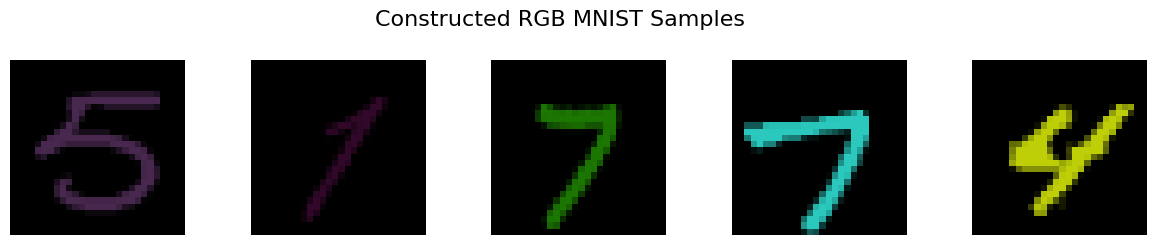

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from torch.utils.data import Dataset, DataLoader
# Load MNIST dataset
(train_images, train_labels), _ = mnist.load_data()

# Select 5 random samples
sample_indices = np.random.choice(len(train_images), 5)

train_images_rgb = np.stack((train_images,) * 3, axis=-1)
random_multipliers = np.random.rand(len(train_images), 1, 1, 3)
train_images_rgb = (train_images_rgb * random_multipliers).astype(np.uint8)  # Convert back to uint8
class ColoredMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

custom_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the numpy array to a PyTorch tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize pixel values
])
colored_mnist_dataset = ColoredMNISTDataset(train_images_rgb, train_labels, transform=custom_transform)
# Plot modified RGB images
plt.figure(figsize=(15, 5))
plt.suptitle('Constructed RGB MNIST Samples', fontsize=16)
for i, index in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_rgb[index])
    plt.axis('off')

plt.show()


In [20]:
models = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(10):
    if i < 5:
        # For the first 3 models, fix num_embeddings and change embedding_dim
        model = VQVAENet(5, 10*i+3,3).to(device)  # Fixed num_embeddings=5, embedding_dim varies from 3 to 43
    else:
        # For the next 3 models, fix embedding_dim and change num_embeddings
        model = VQVAENet(7*(i-4), 3,3).to(device)  # Fixed embedding_dim=3, num_embeddings varies from 10 to 30
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    models.append((model, optimizer))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train a model
def train_model(model, optimizer, data_loader):
    recon_losses = []
    vq_losses = []
    total_losses = []

    model.train()
    for data, _ in tqdm(data_loader, desc="Training", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output, vq_loss = model(data)
        recon_loss = F.mse_loss(output, data)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        recon_losses.append(recon_loss.item())
        vq_losses.append(vq_loss.item())
        total_losses.append(loss.item())

    return recon_losses, vq_losses, total_losses

losses = []

for idx, (model, optimizer) in enumerate(models):
    print(f"Training Model {idx + 1}...")
    train_loader = DataLoader(colored_mnist_dataset, batch_size=32, shuffle=True)  # Use your DataLoader here
    recon_losses, vq_losses, total_losses = train_model(model, optimizer, train_loader)
    losses.append((recon_losses, vq_losses, total_losses))


Training Model 1...


Training: 100%|██████████| 1875/1875 [01:15<00:00, 24.74batch/s]


Training Model 2...


Training: 100%|██████████| 1875/1875 [01:22<00:00, 22.72batch/s]


Training Model 3...


Training: 100%|██████████| 1875/1875 [01:14<00:00, 25.09batch/s]


Training Model 4...


Training: 100%|██████████| 1875/1875 [01:25<00:00, 21.99batch/s]


Training Model 5...


Training: 100%|██████████| 1875/1875 [01:17<00:00, 24.20batch/s]


Training Model 6...


Training: 100%|██████████| 1875/1875 [01:10<00:00, 26.74batch/s]


Training Model 7...


Training: 100%|██████████| 1875/1875 [01:23<00:00, 22.47batch/s]


Training Model 8...


Training: 100%|██████████| 1875/1875 [01:20<00:00, 23.28batch/s]


Training Model 9...


Training: 100%|██████████| 1875/1875 [01:32<00:00, 20.21batch/s]


Training Model 10...


Training: 100%|██████████| 1875/1875 [01:28<00:00, 21.26batch/s]


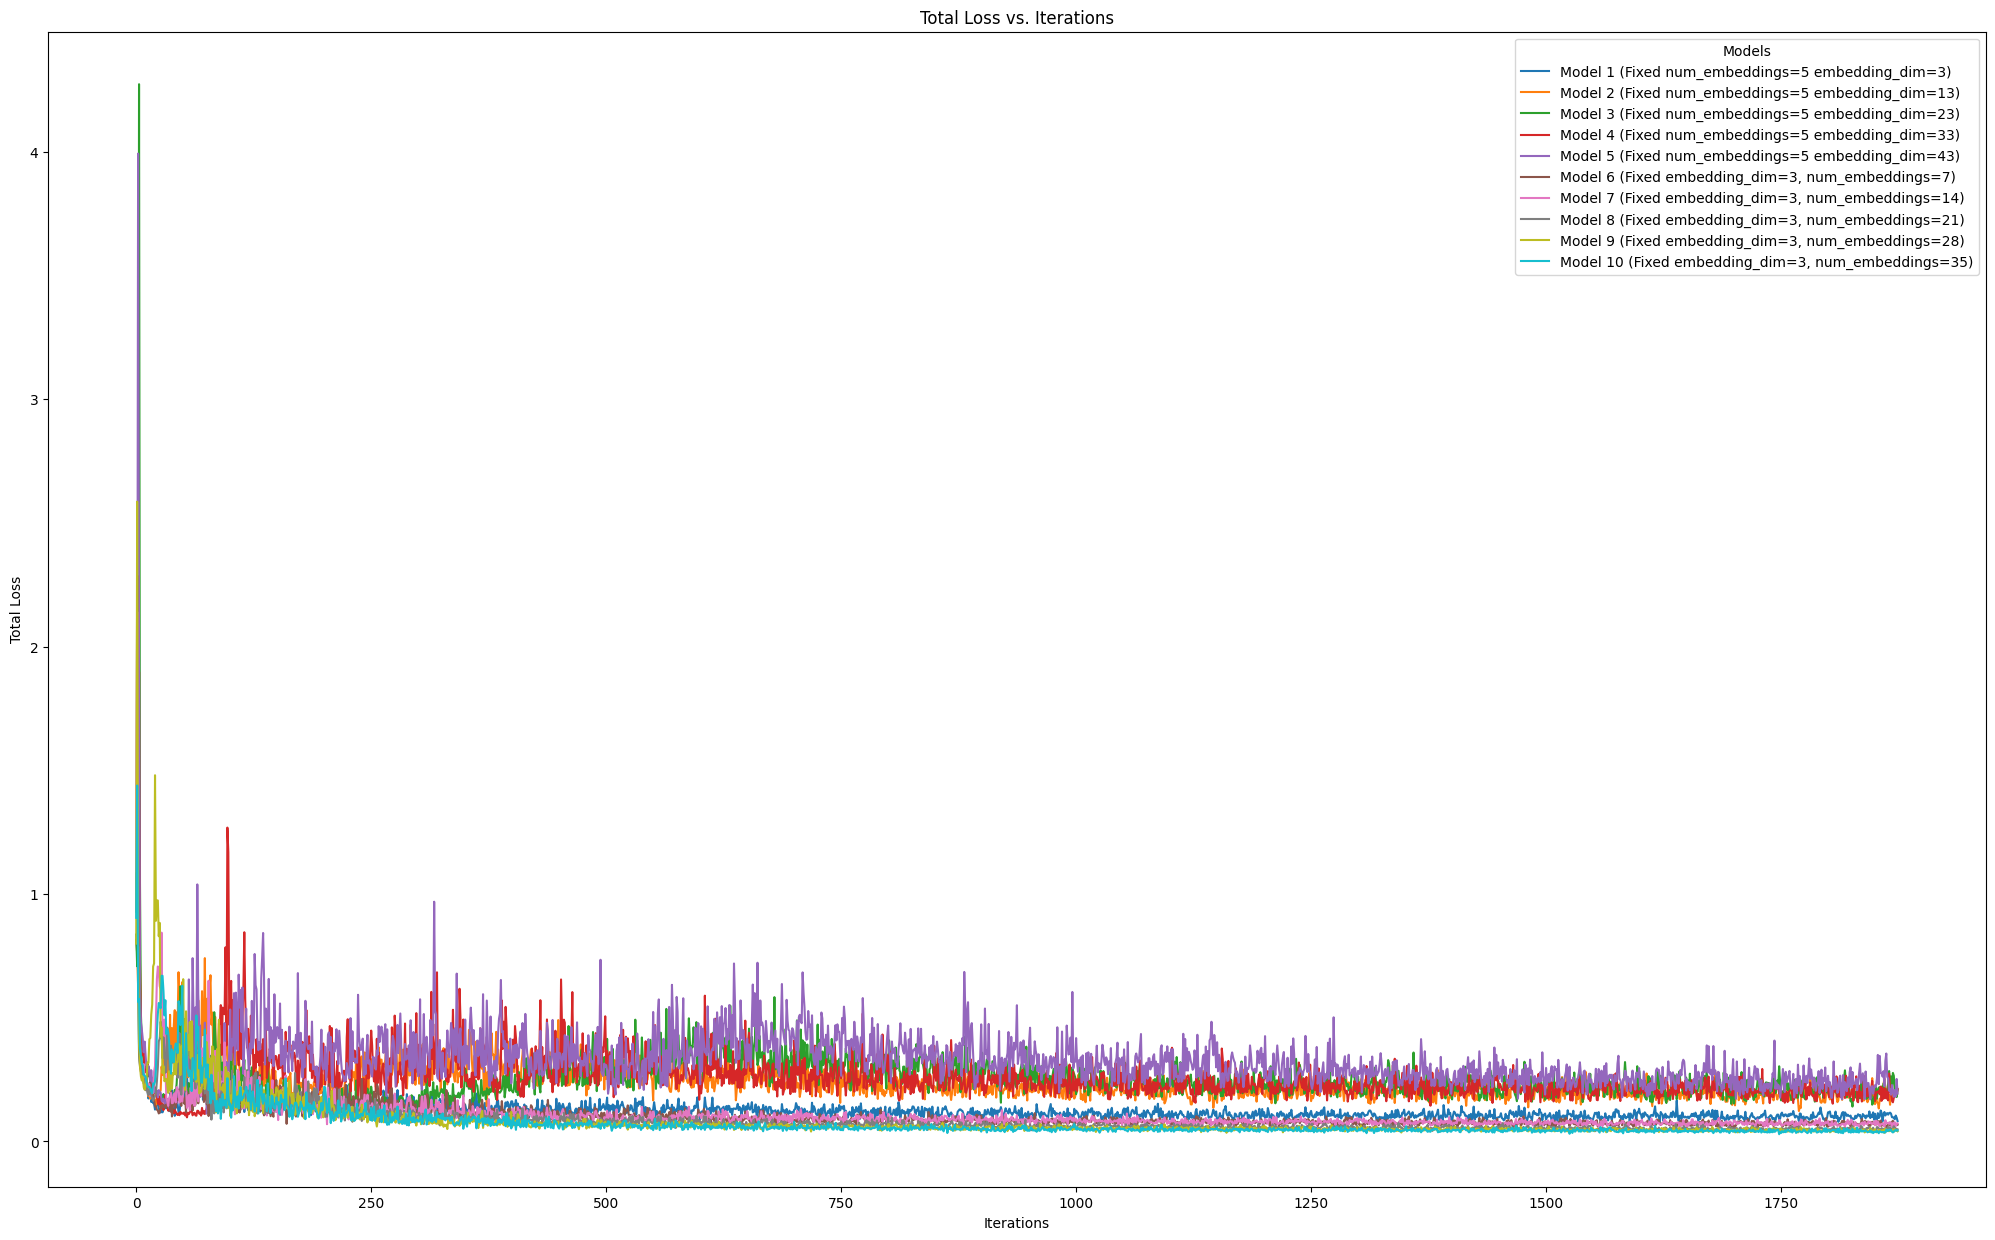

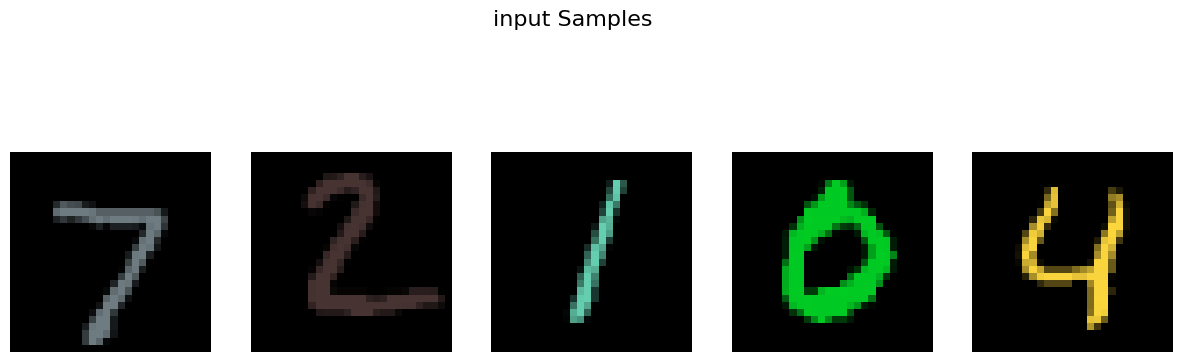

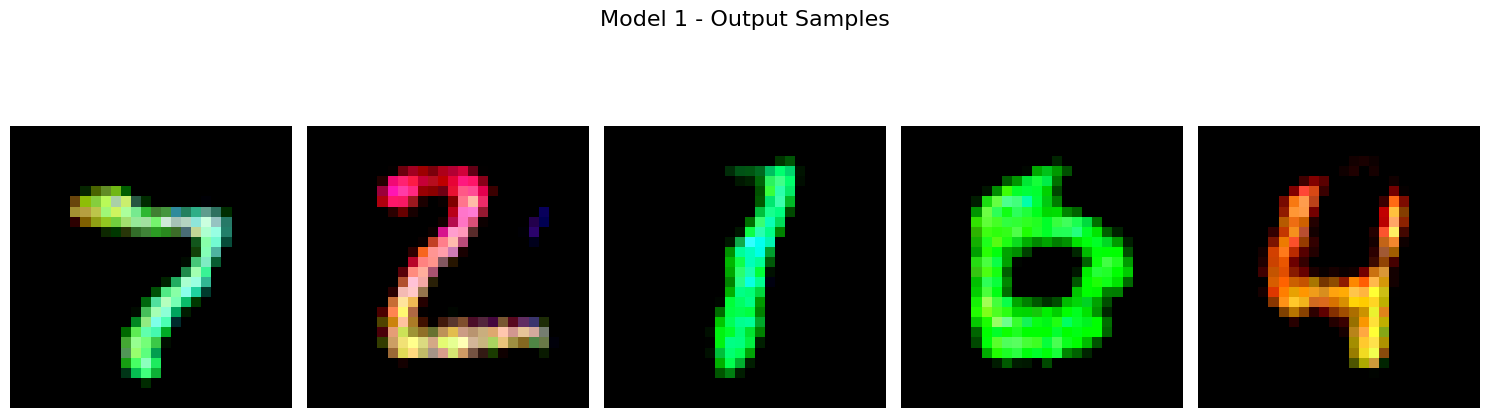

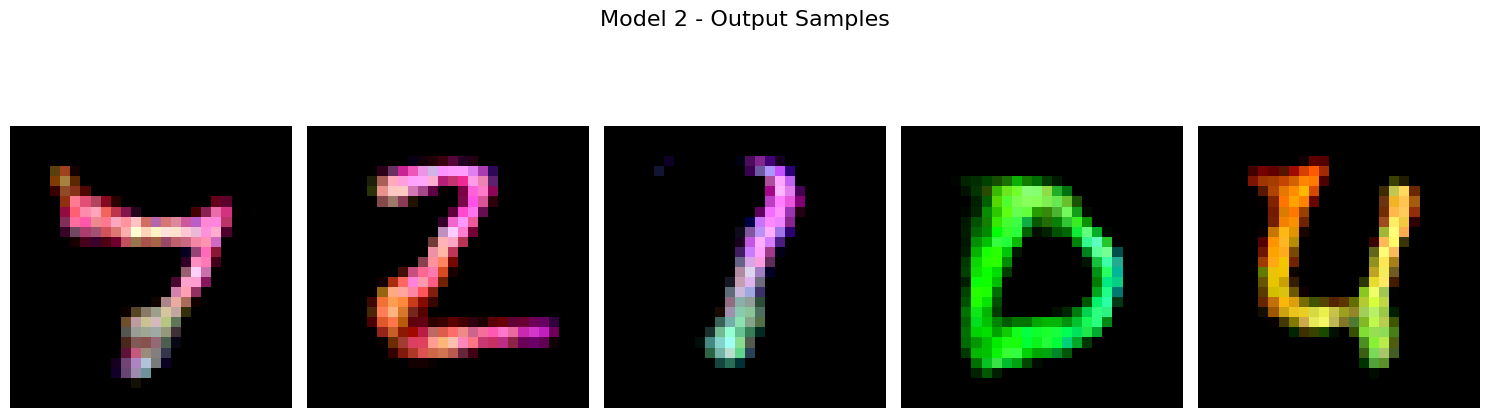

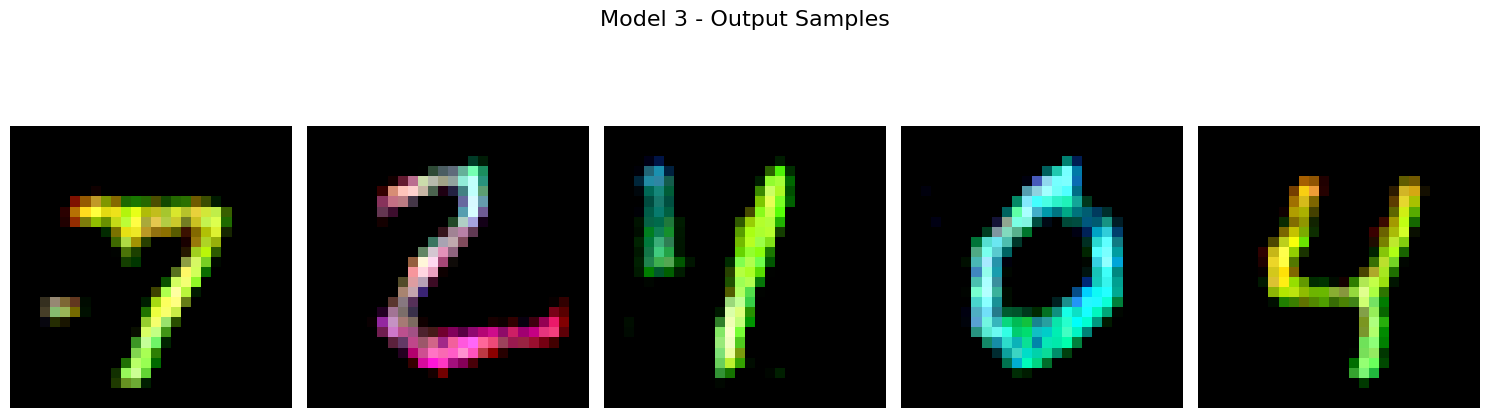

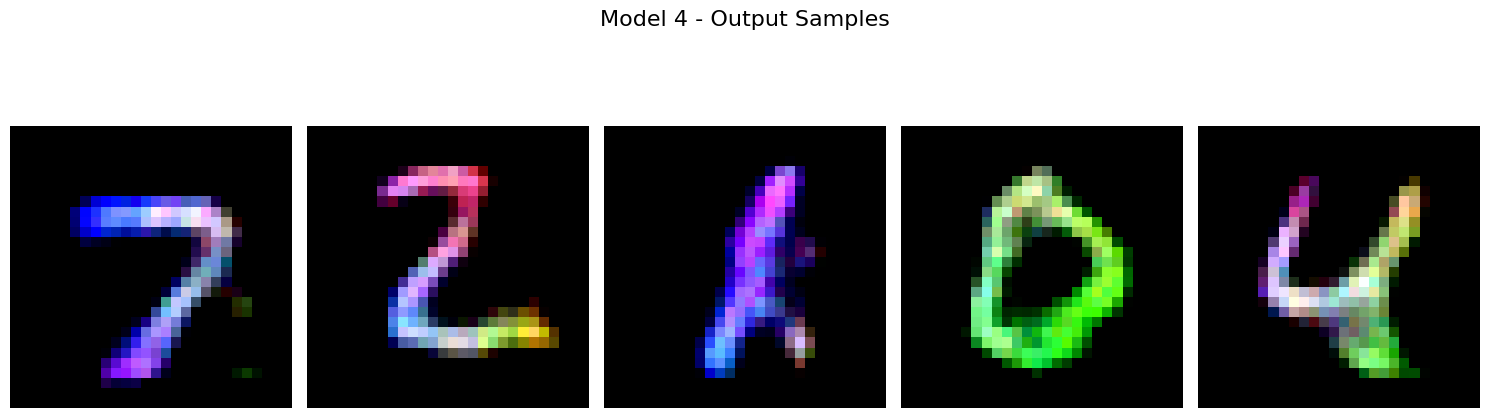

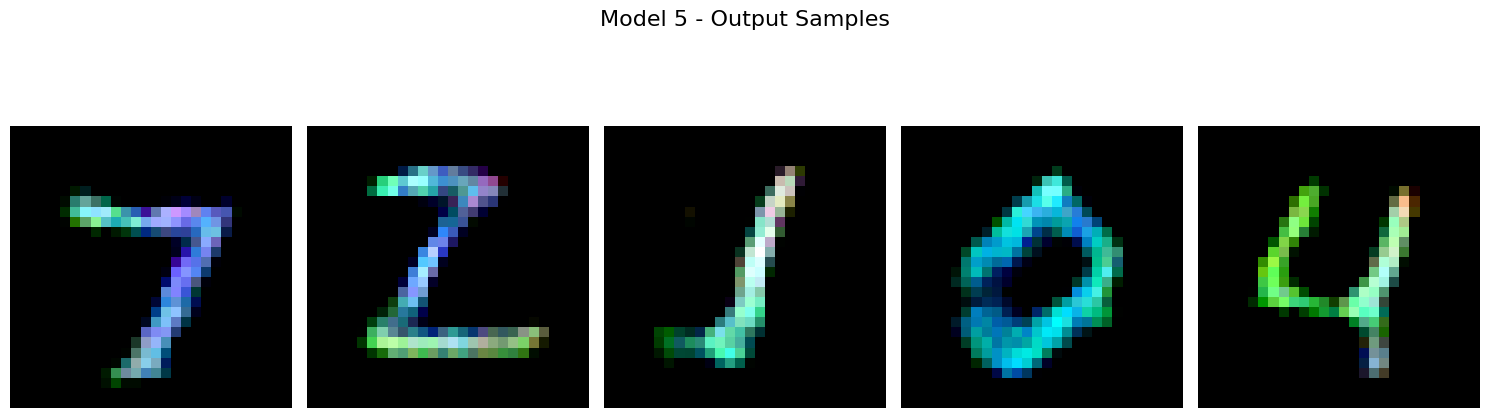

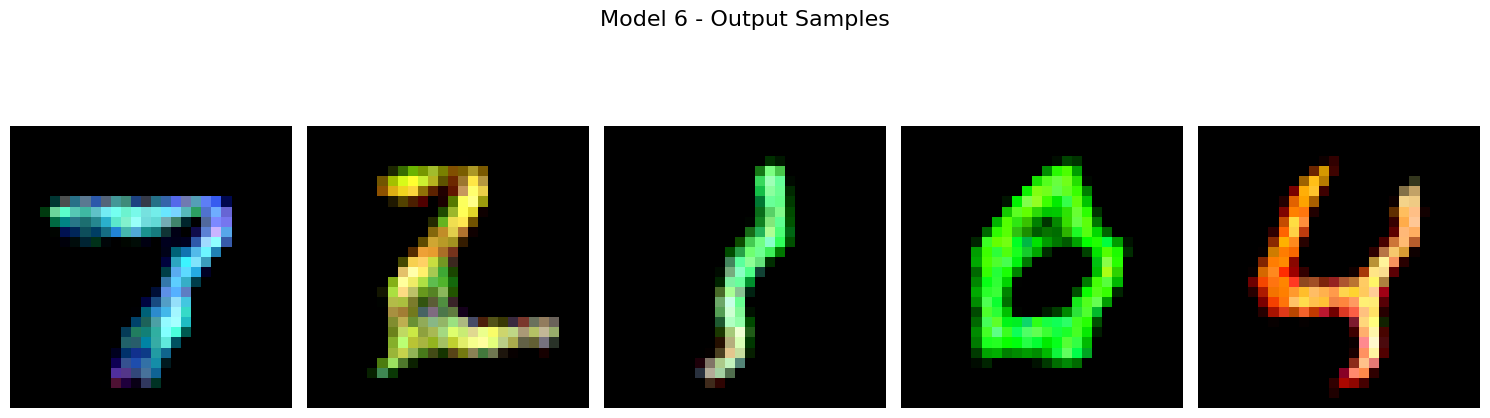

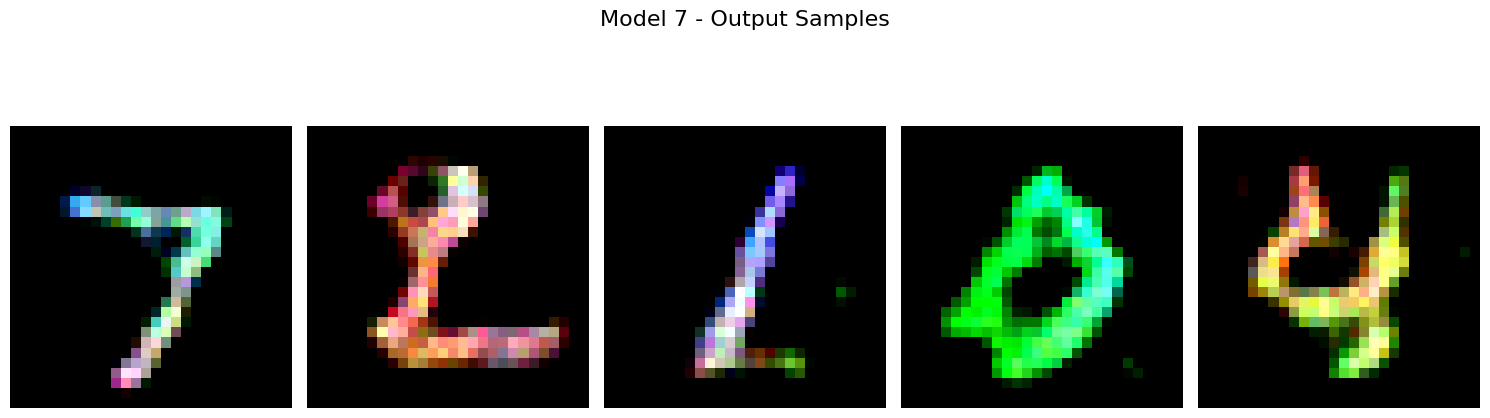

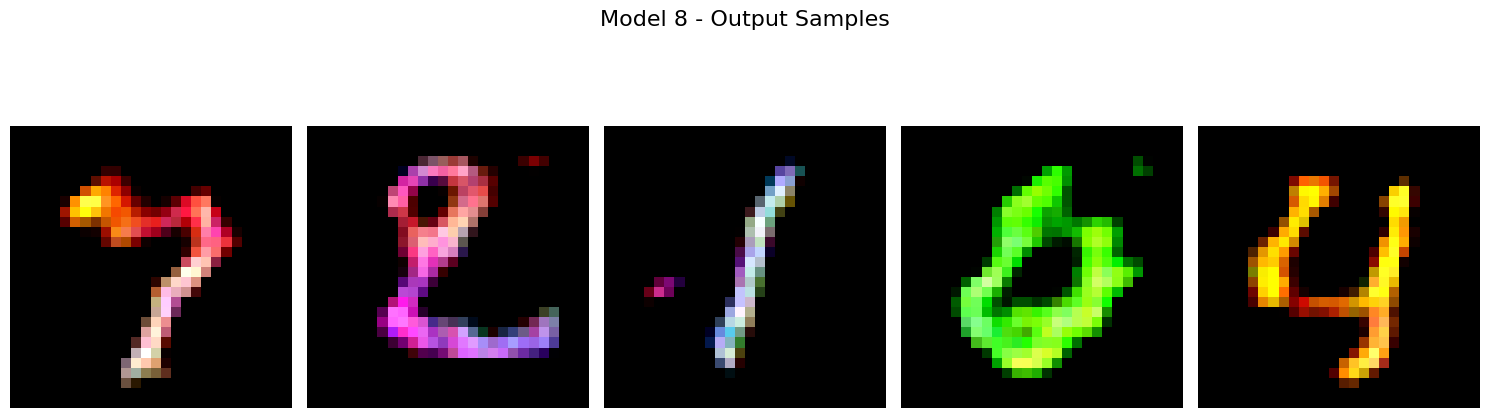

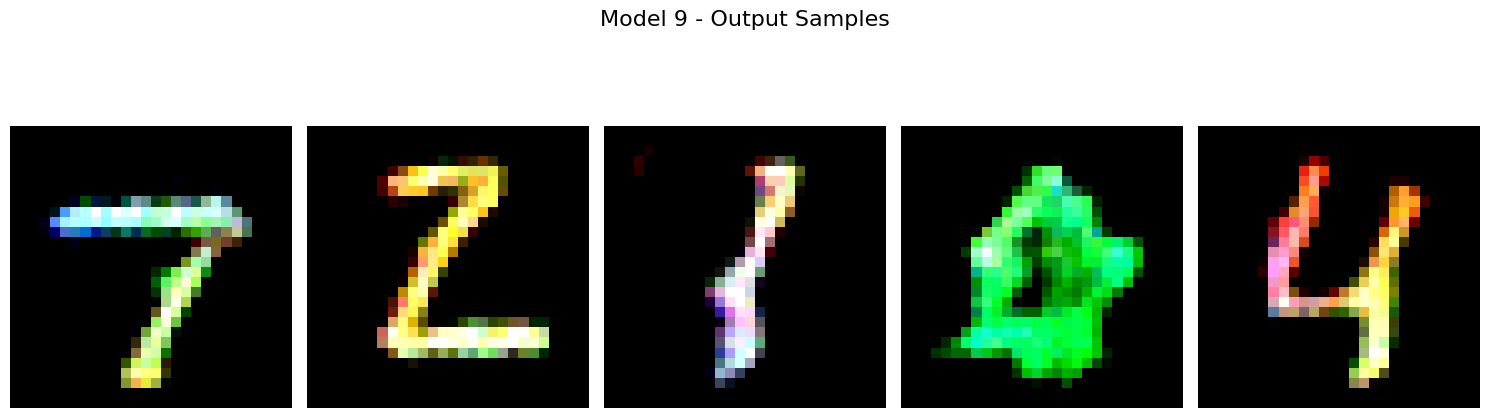

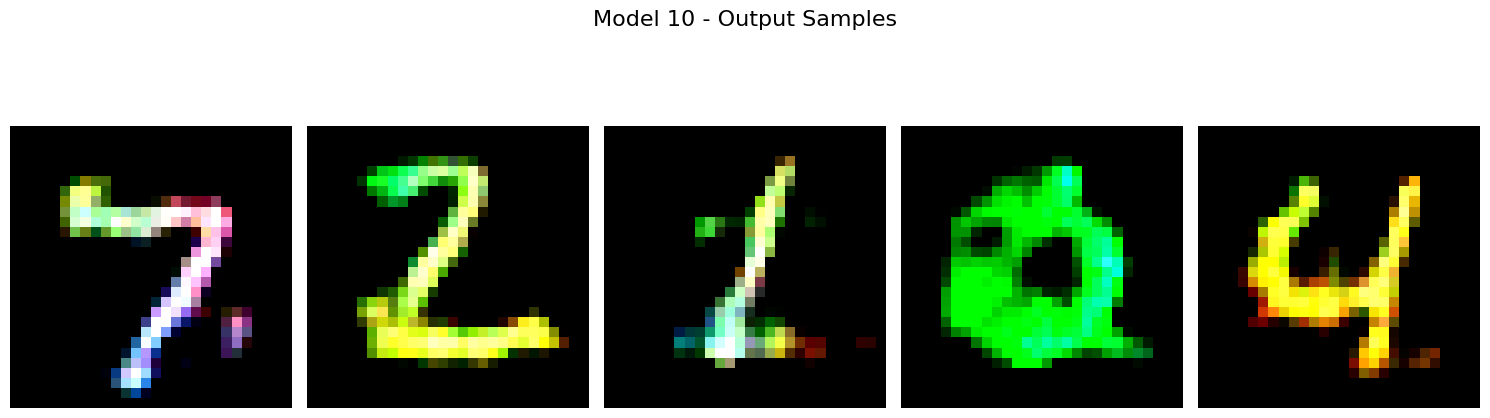

In [26]:
import matplotlib.pyplot as plt

descriptions = [
    "Fixed num_embeddings=5 embedding_dim=3",
    "Fixed num_embeddings=5 embedding_dim=13",
    "Fixed num_embeddings=5 embedding_dim=23",
    "Fixed num_embeddings=5 embedding_dim=33",
    "Fixed num_embeddings=5 embedding_dim=43",
    "Fixed embedding_dim=3, num_embeddings=7",
    "Fixed embedding_dim=3, num_embeddings=14",
    "Fixed embedding_dim=3, num_embeddings=21",
    "Fixed embedding_dim=3, num_embeddings=28",
    "Fixed embedding_dim=3, num_embeddings=35",
]

fig, ax = plt.subplots(figsize=(25, 15))

for i, (recon_losses, vq_losses, total_losses) in enumerate(losses):
    iterations = list(range(len(total_losses)))  # Convert range to a list
    model_description = descriptions[i]

    ax.plot(iterations, total_losses, label=f"Model {i + 1} ({model_description})")

ax.set_title('Total Loss vs. Iterations')
ax.set_xlabel('Iterations')
ax.set_ylabel('Total Loss')
ax.legend(title='Models')

plt.show()

from tensorflow.keras.datasets import mnist
import numpy as np
import torch

# Load MNIST test dataset
(_, _), (test_images, test_labels) = mnist.load_data()

# Convert validation images to RGB similar to the training images
val_images_rgb = np.stack((test_images,) * 3, axis=-1)
random_multipliers_val = np.random.rand(len(test_images), 1, 1, 3)
val_images_rgb = (val_images_rgb * random_multipliers_val).astype(np.uint8)

# Define a new dataset for the validation set
colored_val_dataset = ColoredMNISTDataset(val_images_rgb, test_labels, transform=custom_transform)

# Plot 10 samples from the validation set
plt.figure(figsize=(15, 5))
plt.suptitle('input Samples', fontsize=16)
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(val_images_rgb[i])
    plt.axis('off')

plt.show()

outputs_val = []
for i, (model, _) in enumerate(models):
    model_output_val = []
    for idx in range(5):
        input_image_val = torch.tensor(val_images_rgb[idx], dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)
        model.eval()
        with torch.no_grad():
            output_val, _ = model(input_image_val)
        model_output_val.append(output_val.squeeze().permute(1, 2, 0).cpu().numpy())
    outputs_val.append(model_output_val)

for i, output_val in enumerate(outputs_val):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Model {i + 1} - Output Samples", fontsize=16)
    for j in range(5):
        plt.subplot(1, 5, j + 1)
        plt.imshow(output_val[j])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
